In [1]:
### https://www.kaggle.com/dileep070/heart-disease-prediction-using-logistic-regression
import numpy as np
import pandas as pd 
# classifier models:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
# scaler
from sklearn.preprocessing import StandardScaler
# split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
# matplot libs
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt 
# to reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# scoring
from sklearn.metrics import fbeta_score, make_scorer
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
# to classification report
from sklearn.model_selection import learning_curve
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

Abaixo, funcoes de plots (ou tentativas rs) de plotar o gráfico. O último que postei era essa primeira funcao. Este comentário será apagado em 24 horas, boa noite.

In [2]:
def print_dim_reduced_data(samples_2d, targets):
    # tsne = TSNE(n_components=2, random_state=0) 
    # samples_2d = tsne.fit_transform(samples)
    target_ids = range(2)
    colors = 'r', 'g'
    for i, c, label in zip(target_ids, colors, targets):
        plt.scatter(samples_2d[targets == i, 0], samples_2d[targets == i, 1], c=c, label=label)
    plt.grid(linestyle='--')
    plt.legend(bbox_to_anchor=(1.15, 0.725, 0, 0))
    plt.show()
    plt.close()

In [3]:
def print_val_scores(model, X_train, y_train, scoring=['f1_weighted','f1_macro','recall_weighted','precision_weighted'], 
                     cv=10):
    _,__,f1_w,f1_m,r,p=cross_validate(model, X_train, y_train, cv=cv,
                       scoring=scoring).items()
    mean_f1_w = f1_w[1].mean(); sd_f1_w = f1_w[1].std()
    mean_f1_m = f1_m[1].mean(); sd_f1_m = f1_m[1].std()
    mean_r = r[1].mean(); sd_r = r[1].std()
    mean_p = p[1].mean(); sd_p = p[1].std()
    
    print("Classification report for classifier {}:\nparameters:\n".format(model) +
          "{}\nmean: {}, std deviation: {}\n\n".format(f1_w[0],mean_f1_w,sd_f1_w) +
          "{}\nmean: {}, std deviation: {}\n\n".format(f1_m[0],mean_f1_m,sd_f1_m) +
          "{}\nmean: {}, std deviation: {}\n\n".format(r[0],mean_r,sd_r) +
          "{}\nmean: {}, std deviation: {}\n\n".format(p[0],mean_p,sd_p))

In [4]:
def print_val_custom_score (model, X_train, y_train, 
                            scoring='f1_macro', 
                            cv=10):
    print("Classification report for classifier {}:\nparameters:\n".format(model))
    
    myReturn=cross_validate(model,X_train,y_train,cv=cv,scoring=scoring)
    _,__,metric_score=myReturn
    metric_score=myReturn[metric_score]
    mean = np.mean(metric_score)
    sd = np.std(metric_score)
    print("{}\nmean: {}, std deviation: {}\n\n".format(scoring,mean,sd))

In [5]:
def print_metrics(clf, X, y, prediction):
    print(f"Classification report for classifier {clf}:\n"
          f"{metrics.classification_report(y, prediction)}\n")
    disp = metrics.plot_confusion_matrix(clf, X, y)
    disp.figure_.suptitle("Confusion Matrix")

In [6]:
data=pd.read_csv('heart_pred.csv')
data.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4238.000000,4238.000000,4133.000000,4238.000000,4209.000000,4185.000000,4238.000000,4238.000000,4238.000000,4188.000000,4238.000000,4238.000000,4219.000000,4237.000000,3850.000000,4238.000000
mean,0.429212,49.584946,1.978950,0.494101,9.003089,0.029630,0.005899,0.310524,0.025720,236.721585,132.352407,82.893464,25.802008,75.878924,81.966753,0.151958
std,0.495022,8.572160,1.019791,0.500024,11.920094,0.169584,0.076587,0.462763,0.158316,44.590334,22.038097,11.910850,4.080111,12.026596,23.959998,0.359023
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,89.875000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


Retirando valores nulos e NaN

In [7]:
data=data.dropna()
# data_columns=list(data.columns.values.tolist())
data=data[data.notnull()]
data=data.reset_index()
data.describe()

,index,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000
mean,2122.394967,0.443654,49.557440,1.979759,0.489059,9.022155,0.030361,0.005744,0.311543,0.027079,236.873085,132.368025,82.912062,25.784185,75.730580,81.856127,0.152352
std,1230.175507,0.496883,8.561133,1.022657,0.499949,11.918869,0.171602,0.075581,0.463187,0.162335,44.096223,22.092444,11.974825,4.065913,11.982952,23.910128,0.359411
min,0.000000,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,113.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,1050.750000,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.080000,68.000000,71.000000,0.000000
50%,2139.500000,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.380000,75.000000,78.000000,0.000000
75%,3199.250000,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.250000,144.000000,90.000000,28.040000,82.000000,87.000000,0.000000
max,4237.000000,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,600.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


In [8]:
y=data["TenYearCHD"]
X=data.drop('TenYearCHD',axis=1)

In [9]:
# X = TSNE(n_components=2).fit_transform(X)
pca = PCA(n_components=3)
pca.fit(X)

PCA(n_components=3)

In [10]:
X_reduced=pca.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.20, random_state = 200)

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

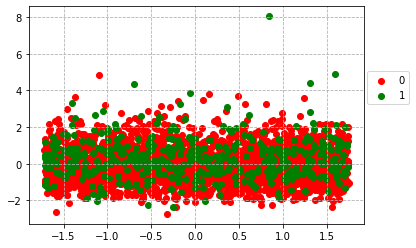

In [12]:
# print data distribution after t-SNE reduction
print_dim_reduced_data(X_train, y_train)
# print_2d_data(X_train, y_train)

In [13]:
f_beta = make_scorer(fbeta_score, beta=2)

In [14]:
# Criar grid para a Random Forest Classifier

max_depth = [int(x) for x in np.linspace(5, 100, num = 5)]
max_depth.append(None)

grid_rfc = {
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 600, num = 6)],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth': max_depth,
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [16]:
clf_rfc = RandomForestClassifier()

#  Random search of parameters. Uses our shuffle selection cross validation, 
#  and search across "n_iter" different (shuffle) combinations, and use all available cores
rfc_search = RandomizedSearchCV(estimator = clf_rfc, param_distributions = grid_rfc, 
                               n_iter = 20, cv = 5, random_state=200, scoring=f_beta)

rfc_search.fit(X_train, y_train)
rfc_search.best_params_

KeyboardInterrupt: 

In [18]:
rfc_search.best_score_

0.8457653466735238

In [30]:
best_grid_rfc = rfc_search.best_estimator_
print_val_scores(best_grid_rfc, X_train, y_train)

Classification report for classifier RandomForestClassifier(max_depth=28, max_features='log2', min_samples_leaf=4,
                       n_estimators=600):
parameters:
test_f1_weighted
mean: 0.7848778807006177, std deviation: 0.0078026774934728035

test_f1_macro
mean: 0.49870089564478814, std deviation: 0.022206474956887334

test_recall_weighted
mean: 0.8437117209780729, std deviation: 0.004437338534083739

test_precision_weighted
mean: 0.7868553412534388, std deviation: 0.03482056789150965




In [54]:
print_val_custom_score(best_grid_rfc, X_train, y_train,f_beta)

Classification report for classifier RandomForestClassifier(max_depth=28, max_features='log2', min_samples_leaf=4,
                       n_estimators=600):
parameters:

0.07142857142857144
mean: 0.050535926808141896, std deviation: 0.022393441165823962




SVM implementarion

In [14]:
clf_svm = make_pipeline(StandardScaler(), SVC())
print(pprint(clf_svm.get_params() ))

{'memory': None,
 'standardscaler': StandardScaler(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'steps': [('standardscaler', StandardScaler()), ('svc', SVC())],
 'svc': SVC(),
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False,
 'verbose': False}
None


É assim que se imprime os parâmetros de cada modelo. Agora, precisa treinar para os demais

In [15]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
C = [float(x) for x in np.linspace(start = 0.1, stop = 100.0, num = 10).astype(float)]
class_weight=['balanced', None,{0:2,1:3},{0:5,1:1},{0:20,1:1},{0:200,1:3},{0:110,1:20}]
kernel = ['linear', 'poly', 'rbf','sigmoid']
gamma = ['scale', 'auto']
decision_function_shape = ['ovo','ovr']
shrinking = [True, False]

grid_svm = {'svc__C': C,
                   'svc__kernel': kernel,
                   'svc__gamma': gamma,
                   'svc__class_weight':class_weight,
                   'svc__decision_function_shape': decision_function_shape,
                   'svc__shrinking': shrinking}
# pprint(grid_svm)

In [ ]:
svm_search = RandomizedSearchCV(estimator = clf_svm, param_distributions = grid_svm, 
                               n_iter = 20, cv = 5, random_state=200, scoring=f_beta)

svm_search.fit(X_train, y_train)
svm_search.best_params_

In [34]:
best_clf_svm = svm_random.best_estimator_
print_val_custom_score(best_clf_svm,X_train,y_train,f_beta)

Classification report for classifier Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=66.7, class_weight='balanced', kernel='linear'))]):
parameters:

make_scorer(fbeta_score, beta=3)
mean: 0.4569187960633475, std deviation: 0.05632518415176265




In [35]:
print_val_scores(best_clf_svm,X_train,y_train)

Classification report for classifier Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=66.7, class_weight='balanced', kernel='linear'))]):
parameters:
test_f1_weighted
mean: 0.7258972122651761, std deviation: 0.02041769182436871

test_f1_macro
mean: 0.5669764493684443, std deviation: 0.025846950704187712

test_recall_weighted
mean: 0.6904939454859975, std deviation: 0.02475955695520791

test_precision_weighted
mean: 0.7885864255100286, std deviation: 0.01632103008099404




Abaixo, as funcoes sao apenas para demonstracao. Precisa primeiramente fazer cross-validation para encontrar os melhores hiperparâmetros, antes de fazer o teste final. As funcoes print_metrics e print_val_score auxiliam o print dos resultados.

In [34]:
m1 = 'Logistic Regression'
lr = LogisticRegression()
model = lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_acc_score = accuracy_score(y_test, lr_predict)
print("confussion matrix")
print(lr_conf_matrix)
print("\n")
print("Accuracy of Logistic Regression:",lr_acc_score*100,'\n')
print(classification_report(y_test,lr_predict))

confussion matrix
[[627   4]
 [ 91  10]]


Accuracy of Logistic Regression: 87.02185792349727 

              precision    recall  f1-score   support

           0       0.87      0.99      0.93       631
           1       0.71      0.10      0.17       101

    accuracy                           0.87       732
   macro avg       0.79      0.55      0.55       732
weighted avg       0.85      0.87      0.83       732



In [35]:
m2 = 'Naive Bayes'
nb = GaussianNB()
nb.fit(X_train,y_train)
nbpred = nb.predict(X_test)
nb_conf_matrix = confusion_matrix(y_test, nbpred)
nb_acc_score = accuracy_score(y_test, nbpred)
print("confussion matrix")
print(nb_conf_matrix)
print("\n")
print("Accuracy of Naive Bayes model:",nb_acc_score*100,'\n')
print(classification_report(y_test,nbpred))

confussion matrix
[[595  36]
 [ 84  17]]


Accuracy of Naive Bayes model: 83.60655737704919 

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       631
           1       0.32      0.17      0.22       101

    accuracy                           0.84       732
   macro avg       0.60      0.56      0.56       732
weighted avg       0.80      0.84      0.81       732



In [36]:
m3 = 'Random Forest Classfier'
rf = RandomForestClassifier(n_estimators=20, random_state=12,max_depth=5)
rf.fit(X_train,y_train)
rf_predicted = rf.predict(X_test)
rf_conf_matrix = confusion_matrix(y_test, rf_predicted)
rf_acc_score = accuracy_score(y_test, rf_predicted)
print("confussion matrix")
print(rf_conf_matrix)
print("\n")
print("Accuracy of Random Forest:",rf_acc_score*100,'\n')
print(classification_report(y_test,rf_predicted))

confussion matrix
[[630   1]
 [ 97   4]]


Accuracy of Random Forest: 86.6120218579235 

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       631
           1       0.80      0.04      0.08       101

    accuracy                           0.87       732
   macro avg       0.83      0.52      0.50       732
weighted avg       0.86      0.87      0.81       732



In [37]:
m5 = 'K-NeighborsClassifier'
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
knn_predicted = knn.predict(X_test)
knn_conf_matrix = confusion_matrix(y_test, knn_predicted)
knn_acc_score = accuracy_score(y_test, knn_predicted)
print("confussion matrix")
print(knn_conf_matrix)
print("\n")
print("Accuracy of K-NeighborsClassifier:",knn_acc_score*100,'\n')
print(classification_report(y_test,knn_predicted))

confussion matrix
[[623   8]
 [ 93   8]]


Accuracy of K-NeighborsClassifier: 86.20218579234972 

              precision    recall  f1-score   support

           0       0.87      0.99      0.93       631
           1       0.50      0.08      0.14       101

    accuracy                           0.86       732
   macro avg       0.69      0.53      0.53       732
weighted avg       0.82      0.86      0.82       732



In [38]:
m6 = 'DecisionTreeClassifier'
dt = DecisionTreeClassifier(criterion = 'entropy',random_state=0,max_depth = 6)
dt.fit(X_train, y_train)
dt_predicted = dt.predict(X_test)
dt_conf_matrix = confusion_matrix(y_test, dt_predicted)
dt_acc_score = accuracy_score(y_test, dt_predicted)
print("confussion matrix")
print(dt_conf_matrix)
print("\n")
print("Accuracy of DecisionTreeClassifier:",dt_acc_score*100,'\n')
print(classification_report(y_test,dt_predicted))

confussion matrix
[[618  13]
 [ 96   5]]


Accuracy of DecisionTreeClassifier: 85.10928961748634 

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       631
           1       0.28      0.05      0.08       101

    accuracy                           0.85       732
   macro avg       0.57      0.51      0.50       732
weighted avg       0.78      0.85      0.80       732



In [41]:
m7 = 'Support Vector Classifier'
svc =  SVC(kernel='rbf', C=2)
svc.fit(X_train, y_train)
svc_predicted = svc.predict(X_test)
svc_conf_matrix = confusion_matrix(y_test, svc_predicted)
svc_acc_score = accuracy_score(y_test, svc_predicted)
print("confussion matrix")
print(svc_conf_matrix)
print("\n")
print("Accuracy of Support Vector Classifier:",svc_acc_score*100,'\n')
print(classification_report(y_test,svc_predicted))

confussion matrix
[[621  10]
 [ 97   4]]


Accuracy of Support Vector Classifier: 85.38251366120218 

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       631
           1       0.29      0.04      0.07       101

    accuracy                           0.85       732
   macro avg       0.58      0.51      0.50       732
weighted avg       0.78      0.85      0.80       732

